# Traffic signals classification with CNN
---

### Make sure we are using GPU

In [2]:
# It should show at least a device of type "GPU"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15193399763191255372
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9781012477458285558
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Preprocessing image

In [23]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 43
IMG_SIZE = 48

def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # roll color axis to axis 0
    img = np.rollaxis(img, -1)
    
    return img

### Loading whole data from file or creating a file which contains whole images and labels for training

Loaded images from training_data.h5

Example image after processing


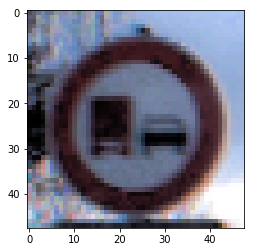

In [28]:
from skimage import io
import os, glob, h5py, random
import matplotlib.pyplot as plt

# Each training image folder contains a number which indicates the image's class/label.
def get_class(img_path):
    return int(img_path.split('\\')[-2])

try:
    # Loading pre-compiled data images and labels
    with  h5py.File('Data\\Saves\\training_data.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print('Loaded images from training_data.h5\n')
    try:
        print('Example image after processing')
        r = random.randint(0, 30000)
        img = X[r]
        img = np.rollaxis(img, 0, start=3)
        plt.figure()
        imgplot = plt.imshow(img)
        plt.show()
    except Exception as e:
        print('It was not possible loading the image')
    
except:
    print('It was not possible to load training saved data. Generating new training_data.h5 file')
    root_dir = 'Data\\Dataset\\Training\\Images\\'
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    num_images = len(all_img_paths)
    print('Number of images to process:', num_images)
    for img_path in all_img_paths:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)
        # Processing progress
        if len(imgs)%4000 == 0:
            print('Processed => {:.2%}'.format(len(imgs)/num_images))

    # Images array
    X = np.array(imgs, dtype='float32')
    # Make one hot targets
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]

    with h5py.File('Data\\Saves\\training_data.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

### Model creation

In [29]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_first')


def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

### Model compilation

In [30]:
from keras.optimizers import SGD

model = cnn_model()
model.summary()

# Model is using SGD + momentum
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 48, 48)        896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 46, 46)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 23, 23)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 23, 23)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 23, 23)        18496     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 21, 21)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 10, 10)        0         
__________

### Training the model and saving it for overfitting check purposes

In [35]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Reduce the learning rate value after each epoch
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 18


try:
    print('Loading model weights')
    model.load_weights('Data\\Saves\\model-cnn.h5')
    print('Successfully loaded weigths, no training needed.')
except:
    print("It was not possible loading the weights, proceding to train")
    history = model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('Data\\Saves\\model-cnn.h5', save_best_only=True)]
          )

Loading model weights
Successfully loaded weigths, no training needed.


### Training and validation accuracy and loss (It won't work without training it)

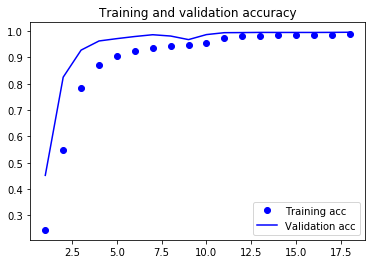

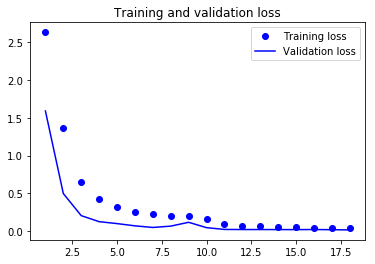

In [32]:
# Printing history of accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Test images

Loaded images from test_data.h5

Example of test image after processing


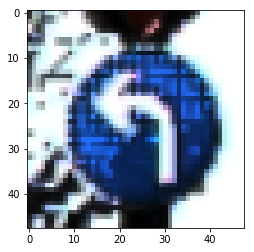

In [33]:
import pandas as pd

try:
    # Loading pre-compiled TEST data images and labels
    with  h5py.File('Data\\Saves\\test_data.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print('Loaded images from test_data.h5\n')
    try:
        print('Example of test image after processing')
        r = random.randint(0, 30000)
        img = X[r]
        img = np.rollaxis(img, 0, start=3)
        plt.figure()
        imgplot = plt.imshow(img)
        plt.show()
    except Exception as e:
        print('It was not possible loading the test image')
except:
    test = pd.read_csv('Data\\Dataset\\GT-final_test.csv',sep=';')

    X_test = []
    y_test = []
    print('Now starting to process test images')
    for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
        img_path = os.path.join('Data\\Dataset\\Test\\Images\\',file_name)
        X_test.append(preprocess_img(io.imread(img_path)))
        y_test.append(class_id)
        # Processing progress
        if len(X_test)%1000 == 0:
            print('Processed => {:.2%}'.format(len(X_test)/len(list(test['Filename']))))
    print('Finished processing test images')    

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    with h5py.File('Data\\Saves\\test_data.h5','w') as hf:
        hf.create_dataset('imgs', data=X_test)
        hf.create_dataset('labels', data=y_test)

### Final model accuracy against test set

In [34]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {:.2%}".format(acc))

Test accuracy = 97.57%
